In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

Feature building

In [3]:
#calculate the percentage change
df['returns'] = df['Close_gold'].pct_change()

In [4]:
#calculate the log returns
#https://quantivity.wordpress.com/2011/02/21/why-log-returns/
df['log_returns'] = np.log(1 + df['returns'])

#drop rows with missing values
df = df.dropna(how='any')

In [5]:
#create feature matrix X
X = df[['Close_gold', 'log_returns']].values

In [6]:
#data normalization with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaler.transform(X)

#create target vector y
y = [x[0] for x in X_scaled]

In [7]:
#data split into train, test and validation sets
split_1 = int(len(X_scaled) * 0.8)
split_2 = int(len(X_scaled) * 0.95)

X_train = X_scaled[:split_1]
X_validation = X_scaled[split_1 : split_2]
X_test = X_scaled[split_2 : len(X_scaled)]
y_train = y[:split_1]
y_validation = y[split_1 : split_2]
y_test = y[split_2 : len(y)]

In [8]:
#test the lengths
assert len(X_train) == len(y_train)
assert len(X_validation) == len(y_validation)
assert len(X_test) == len(y_test)

In [9]:
#labeling
n = 3
Xtrain = []
ytrain = []
Xvalidation = []
yvalidation = []
Xtest = []
ytest = []
for i in range(n, len(X_train)):
    Xtrain.append(X_train[i - n: i, : X_train.shape[1]])
    ytrain.append(y_train[i])
for i in range(n, len(X_test)):
    Xtest.append(X_test[i - n: i, : X_test.shape[1]])
    ytest.append(y_test[i])
for i in range(n,len(X_validation)):
    Xvalidation.append(X_validation[i - n: i, : X_validation.shape[1]])
    yvalidation.append(y_validation[i])

In [10]:
#LSTM inputs reshaping
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xvalidation, yvalidation = (np.array(Xvalidation), np.array(yvalidation))
Xvalidation = np.reshape(Xvalidation, (Xvalidation.shape[0], Xvalidation.shape[1], Xvalidation.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

print(Xtrain.shape)
print(ytrain.shape)
print(Xvalidation.shape)
print(yvalidation.shape)
print(Xtest.shape)
print(ytest.shape)

(4731, 3, 2)
(4731,)
(885, 3, 2)
(885,)
(293, 3, 2)
(293,)


Prediction

In [12]:
from keras.models import load_model
from sklearn.metrics import root_mean_squared_error

model = load_model('/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-04-27-2-monte-carlo/2024-04-27-models/2024-04-27_lstm_model_monte_carlo_28.keras')
#prediction
train_predict = model.predict(Xtrain)
validation_predict = model.predict(Xvalidation)
test_predict = model.predict(Xtest)

train_predict = np.c_[train_predict, np.zeros(train_predict.shape)]
validation_predict = np.c_[validation_predict, np.zeros(validation_predict.shape)]
test_predict = np.c_[test_predict, np.zeros(test_predict.shape)]

#invert prediction
train_predict = scaler.inverse_transform(train_predict)
train_predict = [x[0] for x in train_predict]

validation_predict = scaler.inverse_transform(validation_predict)
validation_predict = [x[0] for x in validation_predict]

test_predict = scaler.inverse_transform(test_predict)
test_predict = [x[0] for x in test_predict]

#calculate square root of mean squared error
train_score = root_mean_squared_error([x[0][0] for x in Xtrain], train_predict)
print('Train Score: %.2f RMSE' % (train_score))

validation_score = root_mean_squared_error([x[0][0] for x in Xvalidation], validation_predict)
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = root_mean_squared_error([x[0][0] for x in Xtest], test_predict)
print('Test Score: %.2f RMSE' % (test_score))

148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train Score: 1004.43 RMSE
Validation Score: 1673.52 RMSE
Test Score: 1862.89 RMSE


/tmp/ipykernel_31107/3806646543.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions'] = test_predict


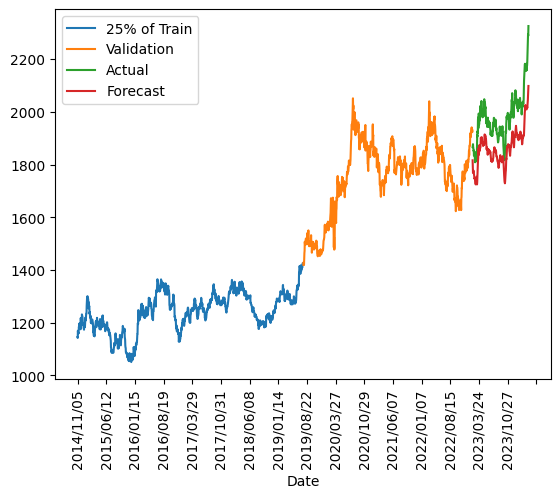

In [13]:
#data split into train and test
df_train = df[n:split_1]
df_validation = df[split_1+n : split_2]
df_test = df[split_2+n : len(X_scaled)]

df_test['predictions'] = test_predict

#plot actual vs predicted values

df_train.set_index('Date', inplace=True)
df_validation.set_index('Date', inplace=True)
df_test.set_index('Date', inplace=True)

plt.plot(df_train.iloc[-(int(0.25*len(df_train))):]['Close_gold'], label='25% of Train')
plt.plot(df_validation['Close_gold'], label='Validation')
plt.plot(df_test['Close_gold'], label='Actual')
plt.plot(df_test['predictions'], label='Forecast')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.show();

Bootstrapping

In [ ]:
#calculate confidence interval using bootstrapping

from scipy.stats import bootstrap

interval = 10 #approximately 2 weeks data
low_ci = []
high_ci = []

for n in range(0, len(df_test) - interval):
    #convert data to sequence
    data = df_test['predictions'][n : n+interval].values.tolist()
    data = (data,)

    bootstrap_ci = bootstrap(data, np.median, confidence_level = .95, random_state = 1, method = 'percentile')
    
    low_ci.append(bootstrap_ci.confidence_interval.low)
    high_ci.append(bootstrap_ci.confidence_interval.high)

In [ ]:
#plt.plot(df_train.iloc[-(int(0.25*len(df_train))):]['Close_gold'], label='25% of Train')
#plt.plot(df_validation['Close_gold'], label='Validation')
plt.plot(df_test['Close_gold'], label='Actual')
plt.plot(df_test['predictions'], label='Forecast')
plt.fill_between(df_test[0:-interval].index, low_ci, high_ci, color='gray', alpha=0.3)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.show();